# <span style="color:green"> Numerical Simulation Laboratory: Numerical Exercises 8 </span>

## <span style="color:darkorange"> Comment on the C++ code - Structure </span>
<span style="color:firebrick"> *NOTE - the requests of both Exercise 08.1 and 08.2 are implemented in the cpp files contained in __Esercizio08.2__*</span><br>
The C++ code of the Exercises 08.1 and 08.2 is based on the class **Variational**, which performs the sampling of a probability distribution and computes the operator average $\langle {\hat H} \rangle_T$. In particular, the class contains:
1. **Data**.
    - The array $\mathrm{Sample}$, containing all the x values sampled by mean of the Metropolis algorithm;
    - The parameters $\mu, \sigma$, the number and length of the blocks (blocking method);
    - The Metropolis range of motion $\mathrm{R_{\Psi}}$ and the steps $\mathrm{R_Mean, R_Sigma}$ for the search of the minimum value of energy;
    - Other parameters related to the minimization process: number of cycles and scaling factors for the steps $\mathrm{R_Mean, R_Sigma}$.

2. **Methods**. Alongside the constructors, the set and get methods, we have the following methods:
    - $\mathrm{Psi, d2\_Psi, H\_Psi}$ and $\mathrm{p}$ return respectively the wave function, its laplacian, the quantity ${\hat H}\Psi$ and the probability amplitude, evaluated at $x$. There exist two versions of each of these functions: one uses the data members $\mu, \sigma$, the other accepts as parameters two generic values of $\mu, \sigma$ (this becomes useful in the search for the minimum);
    - $\mathrm{V}$, which returns the potential evaluated at $x$;
    - two versions of $\mathrm{GenerateUniform}$, which sample the probability distribution $|\Psi|^2$ using the data members or generic parameters $\mu, \sigma$;
    - $\mathrm{ComputeExpH}$ (with the two usual versions), which computes the actual value of energy;
    - $\mathrm{Calibrate}$, allowing to set the acceptance ratio of the Metropolis algorithm close to 50\%;
    - $\mathrm{Minimize}$, which tries to find the minimum of energy by increasing and decreasing the parameters $\mu, \sigma$. In particular, this function relies on the methods $\mathrm{MoveMean}$ and $\mathrm{MoveSigma}$, whose purpose is to evaluate (singularly) the new value of energy at $\mu \pm R_{Mean}$ and $\mu \pm R_{Sigma}$. These functions stop when the values of $H$ form a *valley*. $\mathrm{Minimize}$ tries to overcome this stalemate by scaling $\mathrm{R_{Mean}, R_{Sigma}}$ (with the values given on input) and calling again the two functions. In addition, to help with this task, if the two *Move* functions are not able to improve the value of $H$, the actual *$y$* parameter is displaced by a random value in the interval $[-0.2*\mathrm{R_y}, 0.2*\mathrm{R_y}]$. Since each $\mathrm{R_y}$ is scaled at every iteration, this should ensure the convergence to the desired minimum (for a suitable choice of parameters).
    - Lastly, $\mathrm{Simulate}$ computes the instantaneous and progressive values of $H$, saving the latter on file.

Since the C++ code of the Exercise08.3 heavily relies on the given algorithms, no further description of its files is needed.

## <span style="color:darkorange"> Comment on the C++ code - Usage </span>
All the parameters can be specified by means of the input file **input.dat**, which contains a brief explanation of their meaning. <br>
The output files of Exercise08.2, namely **H_prog.out** (progressive average and errors) and **sample.out** (the probability sampling), are stored in the folder **OutputData**. Instead, the output of Exercise08.3 is divided into three folders:
- PIMC contains all the data inherent to PIMC calculations (four subfolders, corresponding to four values of temperature);
- Minimized gathers the PIGS calculations involving the optimized wavefunction $\Psi_{\mu, \sigma}$;
- Constant contains the PIGS calculations with the projection of $\Psi = 1$.


# <span style="color:darkorange"> Exercise08.2 </span>

We first gather here some bulky code: the Psi functions, which return the evaluation of $\Psi$ or $|\Psi|^2$, the Plot functions and the Read functions. Some data defined here and later will also be used in Exercise08.3.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.core.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import os.path
from scipy.optimize import curve_fit
exp = np.exp

def Vpot(x):
    return (x**2 - 2.5)*x**2

# Numerical solution (matrix method)
def TruePsi2():
    hbar, m, a, N = 1, 1, 10, 1000
    x = np.linspace(-a/2, a/2, N)
    dx = x[1] - x[0]
    V = Vpot(x)
    CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
    H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
    E, psi = np.linalg.eigh(H)
    psi = np.transpose(psi)
    psi = psi/np.sqrt(dx)
    Xtrue = x
    Ytrue = psi[0]
    Ytrue_2 = psi[0]**2
    return Xtrue, Ytrue_2

def ReadSample(filename):
    Sample = []
    with open(filename) as file:
        for line in file:
            Sample.append(float(line))
    return len(Sample), Sample

def ReadProg(filename):
    with open(filename) as file:
        Nblocks, Lblock = [int(file.readline().split()[1]) for i in range(2)] 
        Mean, Sigma = [float(file.readline().split()[1]) for i in range(2)]
        H_av, H_sigma = [], []
        for line in file:
            line = line.split()
            H_av.append(float(line[0]))
            H_sigma.append(float(line[1]))
    return Nblocks, Lblock, Mean, Sigma, H_av, H_sigma

# Plot the table with the system parameters
def PlotTable(Nsample, Nblocks, Lblock, Mean, Sigma):
    display(HTML("""<style>.output { display: flex; align-items: center; text-align: center; } </style> """))
    prec = '%1.3f'
    Text = [["Sample size", Nsample], ["Number of blocks", Nblocks], ["Block length", Lblock], 
             [r"$\mu$", prec % (Mean)],[r"$\sigma$", prec % (Sigma)]]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,0.5))
    table = ax.table(cellText=[Text[i][1:2] for i in range(len(Text))], 
                     rowLabels=[Text[i][0] for i in range(len(Text))], 
                     colLabels=["Value"], loc="center", cellLoc="center", fontsize=15)
    table.set_fontsize(13)
    table.scale(1, 2.4)
    ax.axis("off")
    plt.show()

# Plot the progressive average and error
def PlotProg(Nblocks, Lblock, H_av, H_sigma):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    fig.subplots_adjust(hspace=0.20, wspace=0.27)
    fig.suptitle(r"Simulation - Progressive values of $\langle H \rangle$", y = 0.96, fontsize=16)
    ax.errorbar(np.arange(1, len(H_av)+1), H_av, yerr=H_sigma, color="black", 
                ecolor="tab:green", label=r"Measured $\langle H \rangle$")
    ax.set_xlabel("Blocks", fontsize=12)
    ax.set_ylabel(r"$\langle H \rangle$ [Natural units]", fontsize=12)
    ax.grid(True)
    ax.legend(prop={"size":15}) 

# Plot the histogram of "Sample", the numerical solution ("true") and the one computed via the C++ code
def PlotPsi2(Nsample, Sample, Mean, Sigma, Nbins):
    skip = 100
    X = np.linspace(min(Sample), max(Sample), 1000)
    Y = [Psi2(x, Mean, Sigma) for x in X]
    X_true, Y_true = TruePsi2()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    fig.subplots_adjust(hspace=0.20, wspace=0.27)
    fig.suptitle(r"Simulation - Progressive values of $\langle H \rangle$ for $V(x)=x^4-\frac{5}{2}x^2$", 
                 y = 0.96, fontsize=16)
    counts, bins, _ = ax.hist(Sample, bins = Nbins, density=True, 
            alpha=0.9, color="tab:orange", label=r"Sample distribution")
    ax.plot(X, Y, color="tab:red", label=r"$\Psi^2_{\mu, \sigma}$ from sample", 
            linewidth = 3, zorder=100)
    ax.plot(X_true, Y_true, color="black", label=r"Numerical solution (matrix)", 
            linewidth = 3, zorder=100)
    ax.legend(prop={"size":13}, loc="upper right")
    plt.xlim((-3,3))
    plt.ylim((0, 0.6))
    return X, Y, X_true, Y_true, counts, bins
    
def Psi(x, Mean, Sigma):
    return (exp(-(((x-Mean)/Sigma)**2)/2.)+exp(-(((x+Mean)/Sigma)**2)/2.))

def Psi2(x, Mean, Sigma):
    p = Psi(x, Mean, Sigma)
    Norm = 2*np.sqrt(math.pi)*Sigma * (1 + np.exp(-(Mean/Sigma)**2))
    return p*p/Norm

# Fitting of the histogram -> comparison between the values mu, sigma and the distribution of x
def Fit(f, X, Y, FitPoints): 
    xmin = min(X)
    xmax = max(X)
    x_discrete = np.linspace(xmin, xmax, len(X), endpoint=True) # One for each bin
    p_opt, p_cov = curve_fit(f, x_discrete, Y, bounds=([0.7,0.5],[0.9,0.8]))
    
    x_fit = np.linspace(xmin, xmax, FitPoints, endpoint=True)
    y_fit = f(x_fit, p_opt[0], p_opt[1])
    return x_fit, y_fit, p_opt

### <span style="color:green"> Sampling of $\Psi^2_{\mu, \sigma}$ and minimization of $\langle H \rangle$ </span>

We now proceed with the representation of our results. We first show a table with the essential parameters of the system and the values $\mu, \sigma$, found with the variational method. Then we plot the progressive values of $\langle H \rangle$ and the comparison between the two wavefunctions, generated by the variational and numerical (matrix) methods.

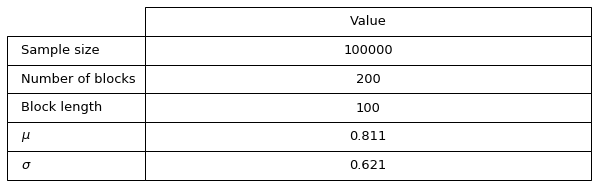

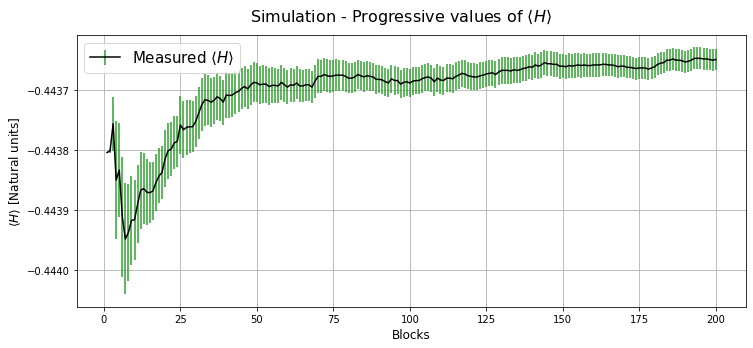

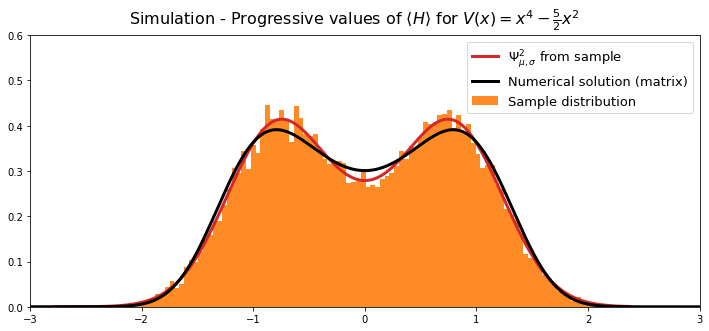

In [2]:
Nsample, Sample = ReadSample("Esercizio08.2/OutputData/sample.out")
Nblocks, Lblock, Mean, Sigma, H_av, H_sigma = ReadProg("Esercizio08.2/OutputData/H_prog.out")
PlotTable(Nsample, Nblocks, Lblock, Mean, Sigma)
PlotProg(Nblocks, Lblock, H_av, H_sigma)

Nbins = 120
X, Y, X_true, Y_true, counts, bins = PlotPsi2(Nsample, Sample, Mean, Sigma, Nbins)

We notice that the average values of $H$ are close to the expected value *-0.460465* for the ground state. We shall also compare the *expected* values of $\mu, \sigma$ (obtained by fitting the numerical solution) and our results. The following table shows that our computation is consistent with the expectations, although we see that the algorithm cannot reach a perfect correspondence with the numerical results. In particular, the optimization in a neighbourhood of the true values of $\mu, \sigma$ has proved to be difficult due to the tendency of these values to oscillate, strongly conditioning the search for the minimum.

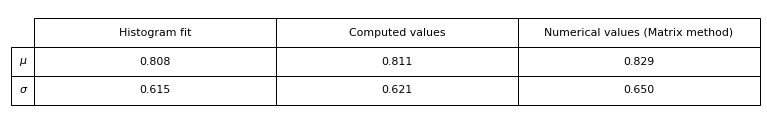

In [3]:
X_hist = [(bins[i]+bins[i+1])/2. for i in range(len(counts))]
_, _, p_opt_hist = Fit(Psi2, X_hist, counts, 10000)
MeanFitHist, SigmaFitHist = p_opt_hist
_, _, p_opt_num = Fit(Psi2, X_true, Y_true, 10000)
MeanNum, SigmaNum = p_opt_num
display(HTML("""<style>.output { display: flex; align-items: center; text-align: center; } </style> """))
prec = '%1.3f'
Text = [[r"  $\mu$  ", prec % (MeanFitHist), prec % (Mean), prec% (MeanNum)],
        [r"  $\sigma$  ", prec % (SigmaFitHist), prec % (Sigma), prec% (SigmaNum)]]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,2))
table = ax.table(cellText=[Text[i][1:4] for i in range(len(Text))], 
                 rowLabels=[Text[i][0] for i in range(len(Text))], 
                 colLabels=["Histogram fit", "Computed values", "Numerical values (Matrix method)"], 
                 loc="center", cellLoc="center", fontsize=16)
table.set_fontsize(13)
table.scale(1, 2.4)
ax.axis("off")
plt.show()

# <span style="color:darkorange"> Exercise08.3 </span>

In this exercise we compare the results of the PIGS and PIMC algorithms with our variational MC method. In general, it turns out that the former are more accurate (if compared with the numerical solution) than the variational MC for a suitable choice of the parameters $T$ and $\tau$. Also, the acceptance ratios of the metropolis algorithm vary widely as $\tau$ increases or decreases (especially in the PIGS case).

In [4]:
def ReadProbability(filename):
    x, average, sigma = [], [], []
    with open(filename) as file:
        for line in file:
            line = line.split()
            x.append(float(line[0]))
            average.append(float(line[1]))
            sigma.append(float(line[2]))
    return x, average, sigma

### <span style="color:green"> PIGS - Optimized $\Psi^2_{\mu, \sigma}$  </span>

We start with the comparison between PIGS ($T=0$, projection of the optimized wavefunction $\Psi^2_{\mu, \sigma}$) and VMC. We see that the three choices of $\tau=2, 5, 8$ do not affect in a substantial way the final result.

In [5]:
Time = [2, 5, 8]
Colors = ["tab:green", "tab:orange", "tab:red"]

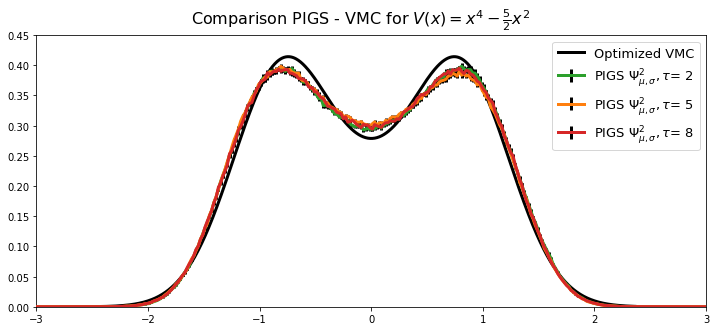

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
fig.subplots_adjust(hspace=0.20, wspace=0.27)
fig.suptitle(r"Comparison PIGS - VMC for $V(x)=x^4-\frac{5}{2}x^2$", 
             y = 0.96, fontsize=16)
for i in range(len(Time)):
    x, average, sigma = ReadProbability("Esercizio08.3/Minimized/PIGS_"+str(int(Time[i]))+"/probability.dat")
    ax.errorbar(x, average, yerr = sigma, color=Colors[i], label=r"PIGS $\Psi^2_{\mu, \sigma}, \tau $"+
                f"= {Time[i]}", linewidth = 3, zorder=100, ecolor="black")
ax.plot(X, Y, color="black", label="Optimized VMC", linewidth = 3)
ax.legend(prop={"size":13}, loc="upper right")
plt.xlim((-3,3))
plt.ylim((0, 0.45))
plt.show()

### <span style="color:green"> PIGS - Constant $\Psi = 1$  </span> 

We start from a constant wavefunction $\Psi = 1$ and consider again the values $\tau=2, 5, 8$. In this case, we see that the change in the value of $\tau$ provokes a much more significant displacement of the curve: in particular, the wavefunction computed with $\tau=2$ is closer to the Optimized VMC, but more inaccurate if compared with the numerical solution.

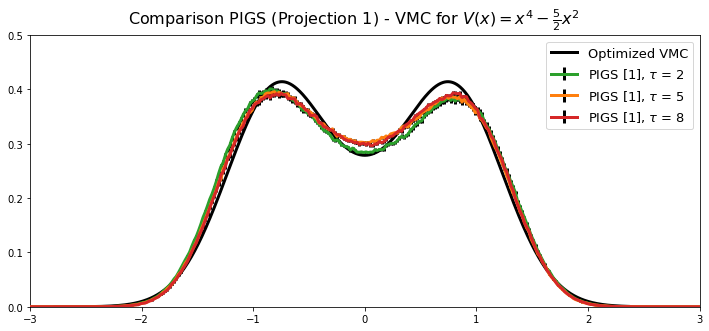

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
fig.subplots_adjust(hspace=0.20, wspace=0.27)
fig.suptitle(r"Comparison PIGS (Projection 1) - VMC for $V(x)=x^4-\frac{5}{2}x^2$", 
             y = 0.96, fontsize=16)
for i in range(len(Time)):
    x, average, sigma = ReadProbability("Esercizio08.3/Constant/PIGS_"+str(int(Time[i]))+"/probability.dat")
    ax.errorbar(x, average, yerr = sigma, color=Colors[i], label=r"PIGS [1], $\tau$ "+
                f"= {Time[i]}", linewidth = 3, zorder=100, ecolor="black")
ax.plot(X, Y, color="black", label="Optimized VMC", linewidth = 3)
ax.legend(prop={"size":13}, loc="upper right")
plt.xlim((-3,3))
plt.ylim((0, 0.5))
plt.show()

### <span style="color:green"> PIMC at different values of $T$ </span> 
We now consider the computation with the PIMC algorithm of $\Psi^2_{\mu, \sigma}$ in the same potential $V(x)=x^4-\frac{5}{2}x^2$ but at different values of temperature $T>0$. We see that for $T = 0.1$ the wavefunction is closer to the one computed numerically, while for higher values of $T$ the mean parameter $\mu$ increases, thus augmenting the distance from the numerical solution.

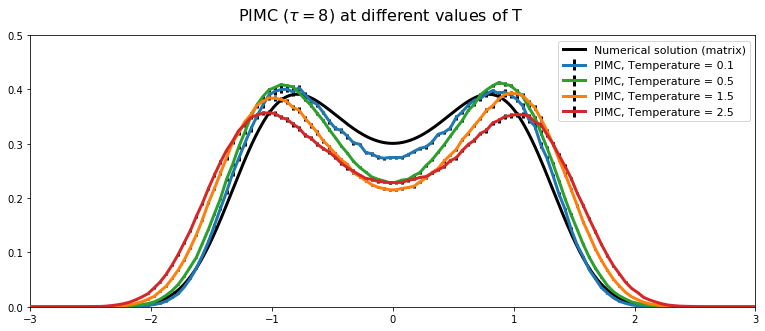

In [8]:
Temp = [0.1, 0.5, 1.5, 2.5]
File = ["0.1", "0.5", "1.5", "2.5"]
Colors = ["tab:blue", "tab:green", "tab:orange", "tab:red"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5))
fig.subplots_adjust(hspace=0.20, wspace=0.27)
fig.suptitle(r"PIMC ($\tau = 8$) at different values of T", 
             y = 0.96, fontsize=16)
for i in range(len(Temp)):
    x, average, sigma = ReadProbability("Esercizio08.3/PIMC/TEMP"+File[i]+"/probability.dat")
    ax.errorbar(x, average, yerr = sigma, color=Colors[i], label=r"PIMC, Temperature = "+
                f"{Temp[i]}", linewidth = 3, zorder=100, ecolor="black")
ax.plot(X_true, Y_true, color="black", label="Numerical solution (matrix)", linewidth = 3)
ax.legend(prop={"size":11}, loc="upper right")
plt.xlim((-3,3))
plt.ylim((0, 0.5))
plt.show()